In [ ]:
!pip install transformers
!pip install datasets
!pip install accelerate

import numpy as np
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.7 MB/s eta 0:00:00


In [ ]:
url = 'https://github.com/gilbertmao/NLP/raw/main/Combined_Annotations.xlsx'
df = pd.read_excel(url)

df['Consumer complaint narrative'] = df['Consumer complaint narrative'].astype(str)

data = df[['Consumer complaint narrative', 'Law Related?']].copy()

data.head()

,Consumer complaint narrative,Law Related?
0,XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX X...,0
1,I recently tried getting my 3 free credit repo...,1
2,There are accounts on my credit report that do...,0
3,These accounts don't belong to me. Please remo...,0
4,I have received XXXX notices from Resurgent Ca...,0


Dataset({
    features: ['Consumer complaint narrative', 'Law Related?', '__index_level_0__'],
    num_rows: 810
})
Dataset({
    features: ['Consumer complaint narrative', 'Law Related?', '__index_level_0__'],
    num_rows: 91
})


<Axes: >

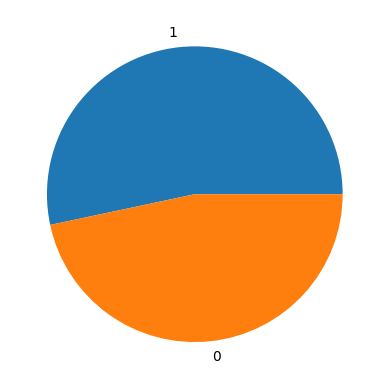

In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset
from datasets import DatasetDict

train, test = train_test_split(data, random_state=42, test_size=0.1, shuffle=True)

train_dataset = Dataset.from_pandas(train)
test_dataset = Dataset.from_pandas(test)

data_dict = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

test_dataset = data_dict["test"]

print(train_dataset)
print(test_dataset)
pd.Series(train_dataset['Law Related?']).value_counts().plot(kind='pie')

In [ ]:
from transformers import AutoTokenizer, AutoConfig

BASE_MODEL = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

unique_labels = data['Law Related?'].unique()

def tokenize(batch):
    # Tokenize the consumer complaint narrative
    inputs = tokenizer(batch["Consumer complaint narrative"], padding=True, truncation=True, max_length=256)
    # Map the labels to their corresponding IDs
    inputs["label"] =batch["Law Related?"]
    return inputs


train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# Update the format of the datasets
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Remove unnecessary columns
remove_columns = ['Consumer complaint narrative', 'Law Related?', '__index_level_0__']
train_dataset = train_dataset.remove_columns(remove_columns)
test_dataset = test_dataset.remove_columns(remove_columns)

print(train)
print(test)

Map:   0%|          | 0/810 [00:00<?, ? examples/s]

Map:   0%|          | 0/91 [00:00<?, ? examples/s]

                          Consumer complaint narrative  Law Related?
643  I am writing to dispute a past due payment on ...             1
168  Please remove these inaccurate accounts from m...             0
311  I attempted to make a {$36.00} purchase and I ...             1
227  XX/XX/2022 visited branch at M & T branch to r...             0
538  This company has infringed on my right to priv...             1
..                                                 ...           ...
106  Im submitting a complaint to you today to info...             1
270  I purchased an item I thought to be a legitima...             0
860  in accordance with the Fair Credit Reporting a...             1
435  I am XXXX XXXX. who is submitting this CFPB co...             1
102  The Tradelines XXXX XXXX XXXX are outdated and...             0

[810 rows x 2 columns]
                          Consumer complaint narrative  Law Related?
70   This is the several times I've complained abou...             0
235  A cre

In [ ]:
from transformers import TrainingArguments
from datasets import load_metric
import numpy as np

training_args = TrainingArguments(output_dir=".",
                                  num_train_epochs=3,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=4,
                                  hub_model_id='ahaanlimaye/ConsumerResponseClassifier',
                                  remove_unused_columns=False,
                                  push_to_hub=False)

metric = load_metric("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="weighted")

**Create Trainer Object**

In [ ]:
from transformers import Trainer
from transformers import AutoModelForSequenceClassification

config = AutoConfig.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, config=config)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

**Train the Model**

In [ ]:
trainer.train()
evaluate_output = trainer.evaluate(test_dataset)
print(evaluate_output)

In [ ]:
from huggingface_hub import login, logout

login()

In [ ]:
trainer.push_to_hub()
tokenizer.push_to_hub("ahaanlimaye/ConsumerResponseClassifier")

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ahaanlimaye/ConsumerResponseClassifier/commit/5fad03035fd329a37f43881e27725d73cffb0a38', commit_message='Upload tokenizer', commit_description='', oid='5fad03035fd329a37f43881e27725d73cffb0a38', pr_url=None, pr_revision=None, pr_num=None)